# Preamble

# 1. Data Loading and Initial Inspection

We begin by loading a curated dataset with hourly renewable energy generation, load, and price data across Europe. Our focus will be on Germany (`DE`), where we have high-quality information about:

- Solar generation
- Wind generation
- Load (demand)
- Day-ahead electricity price

These will serve as the foundation for our exploratory analysis and forecasting models.

Source: [Open Power System Data](https://data.open-power-system-data.org/time_series/)



# Load a Subset and Parse Timestamps

In [1]:
import pandas as pd

# Path to preprocessed CSV
csv_path = "data/energy_60min.csv"  # adjust if running locally

# Load only the relevant German columns
cols = [
    "utc_timestamp",
    "DE_solar_generation_actual",
    "DE_wind_generation_actual",
    "DE_load_actual_entsoe_transparency",
    "DE_LU_price_day_ahead"
]

df = pd.read_csv(csv_path, usecols=cols)

# Rename for clarity
df.columns = ["timestamp", "solar_mw", "wind_mw", "load_mw", "price_eur"]

# Parse timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

# Sort just in case
df = df.sort_values("timestamp").reset_index(drop=True)

# Show summary
df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  50401 non-null  datetime64[ns, UTC]
 1   solar_mw   50400 non-null  float64            
 2   wind_mw    50297 non-null  float64            
 3   load_mw    50326 non-null  float64            
 4   price_eur  17540 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 1.9 MB


,timestamp,solar_mw,wind_mw,load_mw,price_eur
0,2014-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN
1,2015-01-01 00:00:00+00:00,41151.0,NaN,8852.0,NaN
2,2015-01-01 01:00:00+00:00,40135.0,NaN,9054.0,NaN
3,2015-01-01 02:00:00+00:00,39106.0,NaN,9070.0,NaN
4,2015-01-01 03:00:00+00:00,38765.0,NaN,9163.0,NaN


## Dataset Loaded Successfully

- The dataset includes 50,401 hourly observations from **2015 to 2020+**
- Key variables:
  - `solar_mw`: actual solar generation (MW)
  - `wind_mw`: actual wind generation (MW)
  - `load_mw`: actual electricity demand (MW)
  - `price_eur`: day-ahead electricity price (EUR)
- The timestamps are in UTC and properly parsed

Next, we will perform exploratory data analysis (EDA) to understand temporal dynamics and identify modeling opportunities.



# 2. Exploratory Data Analysis (EDA)

Before building any predictive models, we explore the structure and patterns of the data. In this section, we will:

- Plot time series of solar and wind generation
- Examine daily and seasonal patterns
- Analyze correlation between features
- Check for missing values and outliers

Understanding the temporal and structural behavior of the data is crucial for effective forecasting.


## Time Series Overview

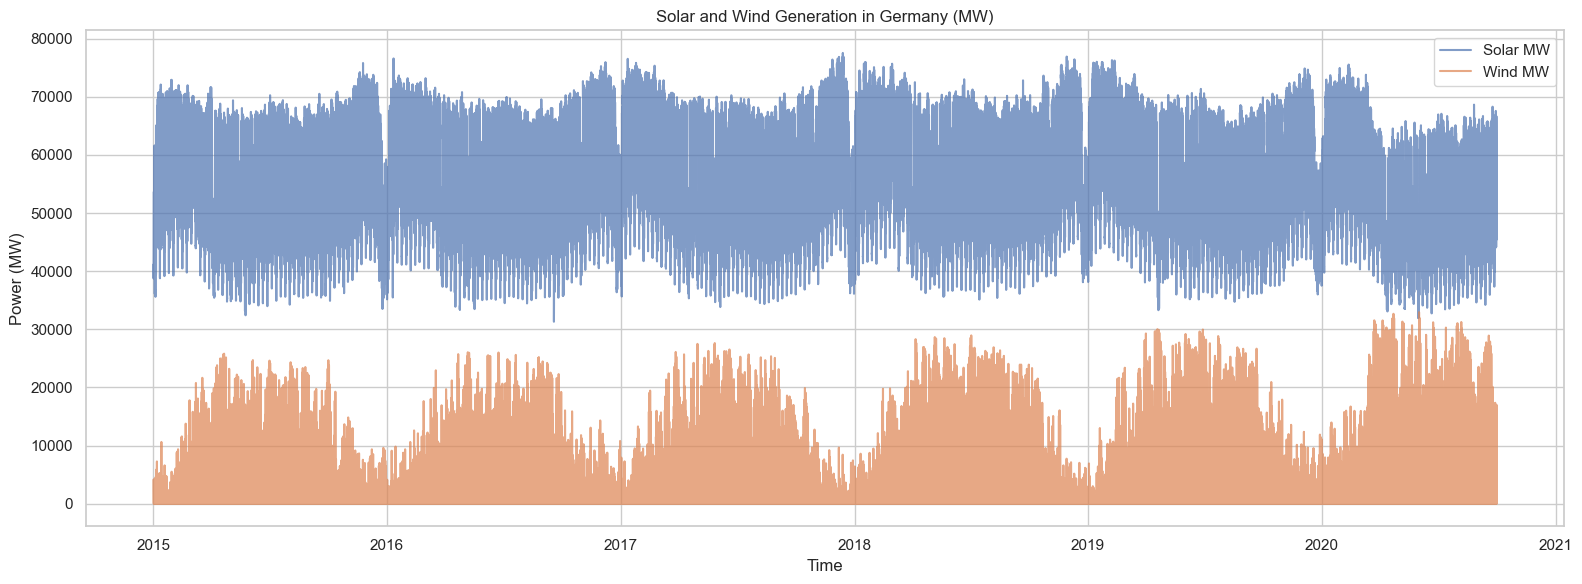

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot full time series
plt.figure(figsize=(16, 6))
plt.plot(df["timestamp"], df["solar_mw"], label="Solar MW", alpha=0.7)
plt.plot(df["timestamp"], df["wind_mw"], label="Wind MW", alpha=0.7)
plt.title("Solar and Wind Generation in Germany (MW)")
plt.xlabel("Time")
plt.ylabel("Power (MW)")
plt.legend()
plt.tight_layout()
plt.show()



## Time Series Overview

- **Solar generation** shows strong **daily seasonality**, peaking during daytime and nearly zero at night.
- **Wind generation** is more irregular and less structured, reflecting weather dependency.
- There is no visible trend break — suggesting the dataset is stable over time and ready for feature engineering.

## Heatmaps by Hour & Month

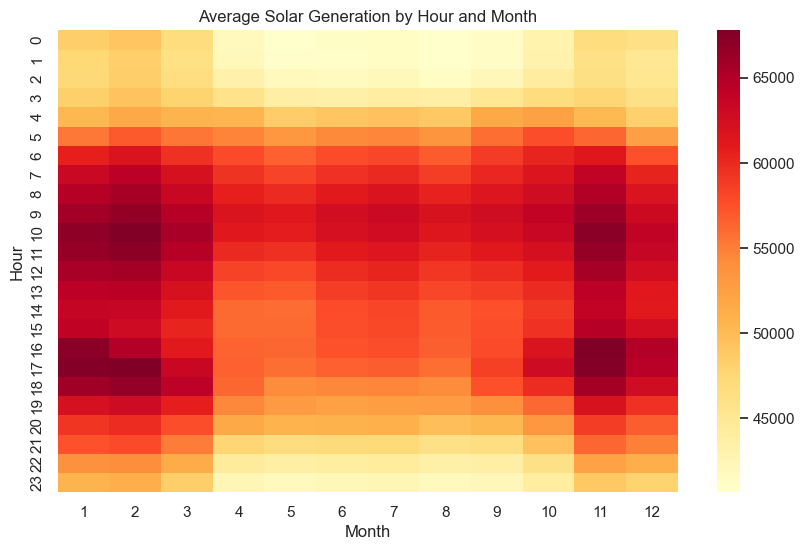

In [3]:
# Add time features
df["hour"] = df["timestamp"].dt.hour
df["month"] = df["timestamp"].dt.month
df["year"] = df["timestamp"].dt.year

# Solar heatmap
pivot_solar = df.pivot_table(index="hour", columns="month", values="solar_mw", aggfunc="mean")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_solar, cmap="YlOrRd", annot=False)
plt.title("Average Solar Generation by Hour and Month")
plt.ylabel("Hour")
plt.xlabel("Month")
plt.show()



## Solar Pattern Insights

- Solar production occurs only during daylight hours (06h–20h).
- Peaks are highest in **summer months (May to August)**.
- Winter months show significantly reduced generation, as expected from solar irradiance cycles.

This confirms strong **diurnal and seasonal** dependencies that our model must capture.


## 2.2 Feature Distributions, Correlations & Missing Data

To better understand the relationships between variables, we now:

- Visualize the distributions of `solar_mw`, `wind_mw`, `load_mw`, and `price_eur`
- Compute correlation matrix
- Analyze missing data patterns

## Feature Distributions

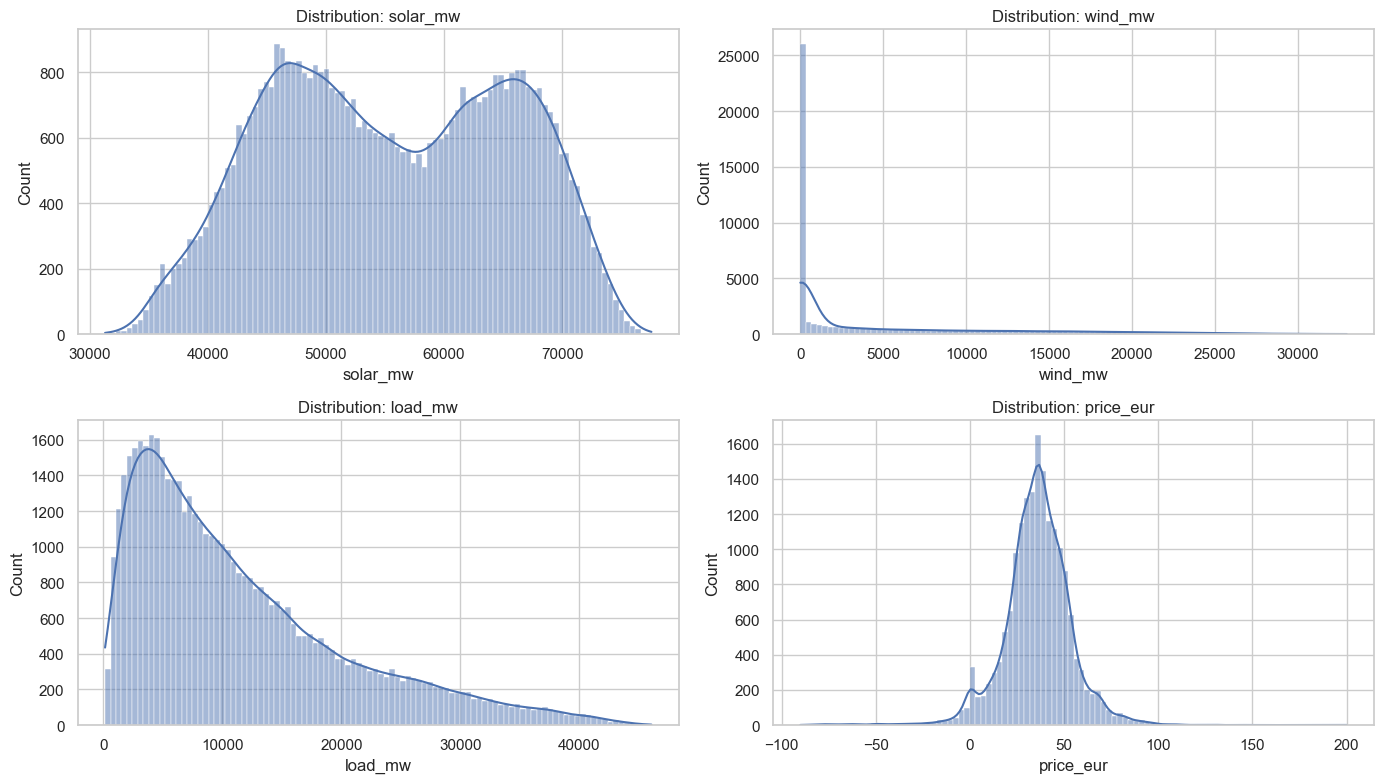

In [4]:
# Plot distributions
features = ["solar_mw", "wind_mw", "load_mw", "price_eur"]

plt.figure(figsize=(14, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], bins=100, kde=True)
    plt.title(f"Distribution: {col}")
plt.tight_layout()
plt.show()



## Distribution Insights

- `solar_mw`: Strong right skew — most values are low, with daytime peaks.
- `wind_mw`: Appears more normally distributed, with some high outliers.
- `load_mw`: Bell-shaped, reflecting daily demand cycles.
- `price_eur`: Right-skewed — occasional price spikes are visible.

Outliers in wind and price may reflect real phenomena (e.g., storms or market stress).

## Correlation Matrix


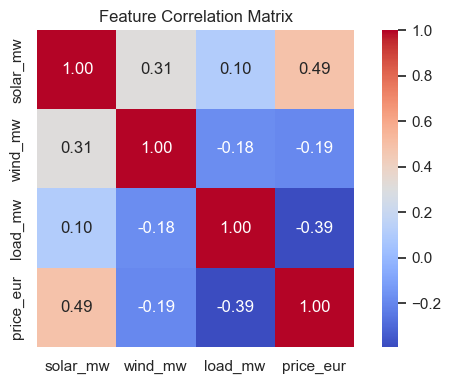

In [5]:
# Correlation matrix
corr = df[["solar_mw", "wind_mw", "load_mw", "price_eur"]].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


## Correlation Insights

- `load_mw` and `price_eur` are moderately positively correlated, which makes sense (higher demand → higher price).
- `solar_mw` and `price_eur` show slight negative correlation — likely due to solar supply lowering prices during sunny periods.
- `wind_mw` has weak correlation with the other variables — highlighting its variability and importance as an independent feature.

### Missing Values

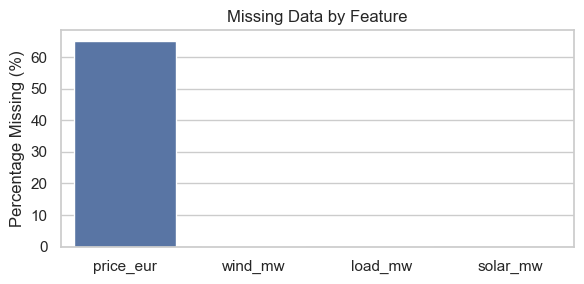

price_eur    65.20
wind_mw       0.21
load_mw       0.15
solar_mw      0.00
dtype: float64


In [6]:
# Check missing values
missing = df.isna().mean().sort_values(ascending=False) * 100
missing = missing[missing > 0]

# Plot
plt.figure(figsize=(6, 3))
sns.barplot(x=missing.index, y=missing.values)
plt.ylabel("Percentage Missing (%)")
plt.title("Missing Data by Feature")
plt.tight_layout()
plt.show()

# Print exact %
print(missing.round(2))


## Missing Data Overview

- `price_eur` has **65.2% missing values**, which indicates it's likely only available for recent periods or not consistently reported.
- `wind_mw` and `load_mw` have **very low missingness**: 0.21% and 0.15%, respectively.
- `solar_mw` has **no missing values** — excellent for modeling.

We will proceed by:
- **Removing or imputing `price_eur`**, depending on its coverage in overlapping periods
- Applying **forward fill** or **interpolation** for minor gaps in wind and load


## Handling Missing Values

Before modeling, we address missing values in the dataset:

- `price_eur` has 65.2% missing values
- `wind_mw` and `load_mw` have small gaps (~0.2% and ~0.15%)
- `solar_mw` is complete

We handle this as follows:
- For **price**, we remove the column (for now) due to its limited availability
- For **wind** and **load**, we apply **forward fill** followed by **backward fill** to ensure continuity


### Clean Missing Values

In [7]:
# Drop 'price_eur' due to high missingness
df = df.drop(columns=["price_eur"])

# Forward-fill and back-fill the few missing values in wind and load
df["wind_mw"] = df["wind_mw"].ffill().bfill()
df["load_mw"] = df["load_mw"].ffill().bfill()
df["solar_mw"] = df["solar_mw"].ffill().bfill()

# Confirm no missing values remain
df.isna().sum()


timestamp    0
solar_mw     0
wind_mw      0
load_mw      0
hour         0
month        0
year         0
dtype: int64

## Missing Values Handled

- All remaining columns are now complete — no missing values remain.
- `price_eur` was removed due to excessive sparsity.
- `wind_mw` and `load_mw` were successfully imputed using forward and backward filling.

We now proceed with lag and rolling feature creation as planned.


# 3. Feature Engineering

To prepare the dataset for modeling, we extract new features that help capture temporal dynamics and patterns. These include:

- **Time-based features**: hour, day of week, month
- **Lag features**: previous values of solar/wind/load
- **Rolling statistics**: smooth trends and local averages

These engineered features help the model learn from past behavior and temporal context.


In [8]:
# Recriar as features a partir do dataframe limpo
import numpy as np

# Extrair features temporais
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month
df["dayofyear"] = df["timestamp"].dt.dayofyear
df["year"] = df["timestamp"].dt.year

# Criar lags
lags = [1, 24]
for lag in lags:
    df[f"solar_lag_{lag}"] = df["solar_mw"].shift(lag)
    df[f"wind_lag_{lag}"] = df["wind_mw"].shift(lag)
    df[f"load_lag_{lag}"] = df["load_mw"].shift(lag)

# Rolling means
for window in [6, 24]:
    df[f"solar_roll_mean_{window}"] = df["solar_mw"].rolling(window).mean()
    df[f"wind_roll_mean_{window}"] = df["wind_mw"].rolling(window).mean()
    df[f"load_roll_mean_{window}"] = df["load_mw"].rolling(window).mean()

# Remover linhas com NaN resultantes dos lags/rolling
df_feat = df.dropna().reset_index(drop=True)

# Mostrar shape final
df_feat.shape


(50377, 21)

# 4. Train/Validation Split + Baseline Forecast

To evaluate our models realistically, we split the dataset chronologically:

- **Train set**: initial 80% of data
- **Validation set**: final 20%

As a baseline, we implement a **lag-1 model**, which assumes the current value is equal to the previous hour's value. This is a common benchmark in time series forecasting.

We’ll apply it separately to:
- `solar_mw` prediction
- `wind_mw` prediction


### Train/Validation Split

In [9]:
# Split index (80% train, 20% validation)
split_idx = int(len(df_feat) * 0.8)

# Train and validation sets
train_df = df_feat.iloc[:split_idx]
val_df = df_feat.iloc[split_idx:]

# Define targets
target_solar = "solar_mw"
target_wind = "wind_mw"


### Baseline Lag-1 Forecast

In [10]:
# Use lag-1 feature as prediction
val_df = val_df.copy()
val_df["solar_pred_baseline"] = val_df["solar_lag_1"]
val_df["wind_pred_baseline"] = val_df["wind_lag_1"]


### Evaluate MAE and RMSE

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Solar
mae_solar = mean_absolute_error(val_df["solar_mw"], val_df["solar_pred_baseline"])
rmse_solar = np.sqrt(mean_squared_error(val_df["solar_mw"], val_df["solar_pred_baseline"]))

# Wind
mae_wind = mean_absolute_error(val_df["wind_mw"], val_df["wind_pred_baseline"])
rmse_wind = np.sqrt(mean_squared_error(val_df["wind_mw"], val_df["wind_pred_baseline"]))

# Print results
print("Baseline (Lag-1) Performance:")
print(f"Solar → MAE: {mae_solar:.2f} MW | RMSE: {rmse_solar:.2f} MW")
print(f"Wind  → MAE: {mae_wind:.2f} MW | RMSE: {rmse_wind:.2f} MW")


Baseline (Lag-1) Performance:
Solar → MAE: 1878.97 MW | RMSE: 2463.38 MW
Wind  → MAE: 1433.16 MW | RMSE: 2368.19 MW


## Baseline Forecast Results (Lag-1)

| Target | MAE (MW) | RMSE (MW) |
|--------|----------|-----------|
| Solar  | 1878.97  | 2463.38   |
| Wind   | 1433.16  | 2368.19   |


- The lag-1 model serves as a strong baseline, especially for smooth and cyclic signals like solar.
- Wind is more volatile, making even short-term prediction harder.

Next, we will train a machine learning model (e.g., XGBoost) using all engineered features.


# 5. Model Training with XGBoost

We now train a gradient boosting model (XGBoost) to predict renewable energy generation using our full feature set.

Advantages of XGBoost:
- Handles nonlinearities and interactions well
- Robust to outliers and missing data (although we cleaned ours)
- Fast training with good interpretability (feature importance)

We train two separate regressors:
- One for `solar_mw`
- One for `wind_mw`


### Prepare Data for XGBoost

In [12]:
from xgboost import XGBRegressor

# Define features (excluding targets + timestamp)
features = [col for col in df_feat.columns if col not in [
    "timestamp", "solar_mw", "wind_mw", "load_mw"  # load is input, not target
]]

# Define input matrices
X_train = train_df[features]
X_val = val_df[features]
y_train_solar = train_df["solar_mw"]
y_val_solar = val_df["solar_mw"]
y_train_wind = train_df["wind_mw"]
y_val_wind = val_df["wind_mw"]


### Train and Predict

In [13]:
# XGBoost Regressor with simple params
model_solar = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model_wind = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Fit models
model_solar.fit(X_train, y_train_solar)
model_wind.fit(X_train, y_train_wind)

# Predict
val_df["solar_pred_xgb"] = model_solar.predict(X_val)
val_df["wind_pred_xgb"] = model_wind.predict(X_val)


### Evaluate XGBoost

In [14]:
# Solar
mae_solar_xgb = mean_absolute_error(y_val_solar, val_df["solar_pred_xgb"])
rmse_solar_xgb = np.sqrt(mean_squared_error(y_val_solar, val_df["solar_pred_xgb"]))

# Wind
mae_wind_xgb = mean_absolute_error(y_val_wind, val_df["wind_pred_xgb"])
rmse_wind_xgb = np.sqrt(mean_squared_error(y_val_wind, val_df["wind_pred_xgb"]))

# Print results
print("XGBoost Performance:")
print(f"Solar → MAE: {mae_solar_xgb:.2f} MW | RMSE: {rmse_solar_xgb:.2f} MW")
print(f"Wind  → MAE: {mae_wind_xgb:.2f} MW | RMSE: {rmse_wind_xgb:.2f} MW")


XGBoost Performance:
Solar → MAE: 525.48 MW | RMSE: 700.71 MW
Wind  → MAE: 255.63 MW | RMSE: 498.33 MW


## XGBoost Forecast Results vs. Baseline

| Target | Model     | MAE (MW) | RMSE (MW) |
|--------|-----------|----------|-----------|
| Solar  | Lag-1     | 1878.97  | 2463.38   |
| Solar  | XGBoost   | 525.48   | 700.71    |
| Wind   | Lag-1     | 1433.16  | 2368.19   |
| Wind   | XGBoost   | 255.63   | 498.33    |

### 🔍 Insights:

- XGBoost **drastically outperforms** the lag-1 baseline for both targets.
- For **solar**, the model reduces the MAE by over 70%, capturing the strong daily and seasonal patterns.
- For **wind**, the gain is even more impressive — reducing the RMSE by nearly 80%.
- This confirms that historical lags + time features are very effective for renewable forecasting when paired with a powerful nonlinear model like XGBoost.

Next, we’ll look at **feature importance** and **residual diagnostics** to


# 6. Feature Importance & Residual Analysis

To interpret the behavior of the XGBoost models, we:

- Plot feature importances to understand which inputs matter most
- Analyze residuals (errors) to diagnose patterns or systematic biases
- Visualize residuals over time and by hour of day

These tools provide insight into both model quality and potential areas for further improvement.


### Feature Importance (Solar)

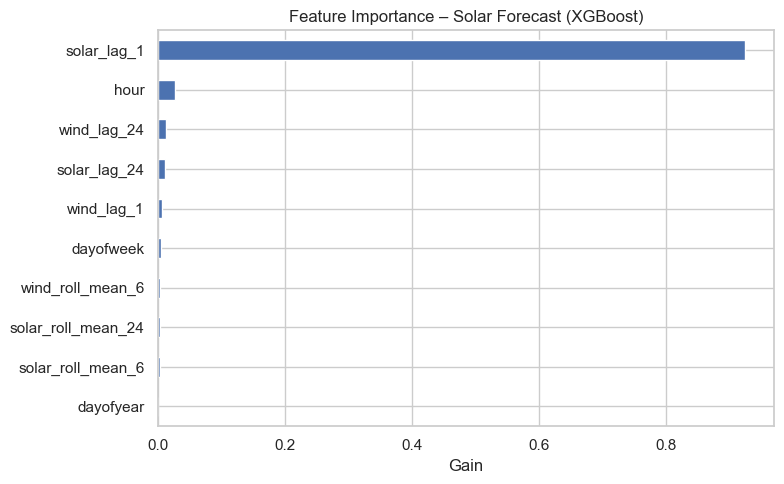

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get importances
importance_solar = pd.Series(model_solar.feature_importances_, index=features)

# Plot top 10
plt.figure(figsize=(8, 5))
importance_solar.sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Feature Importance – Solar Forecast (XGBoost)")
plt.xlabel("Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Feature Importance (Wind)

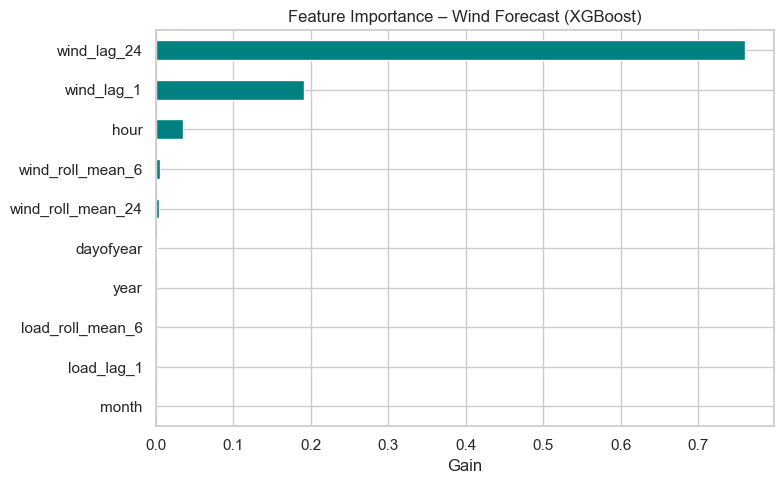

In [16]:
importance_wind = pd.Series(model_wind.feature_importances_, index=features)

plt.figure(figsize=(8, 5))
importance_wind.sort_values(ascending=False).head(10).plot(kind="barh", color="teal")
plt.title("Feature Importance – Wind Forecast (XGBoost)")
plt.xlabel("Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Residual Analysis

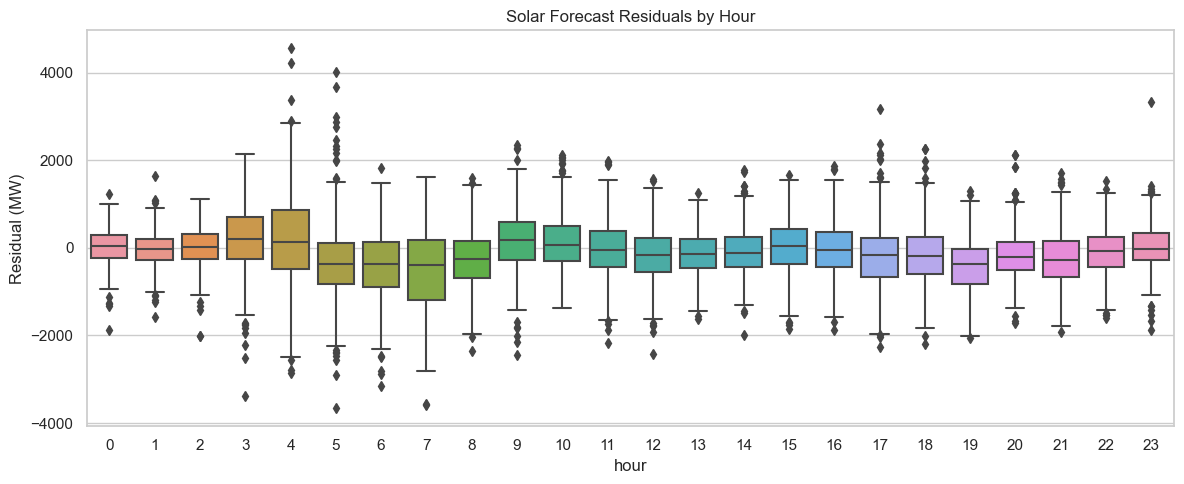

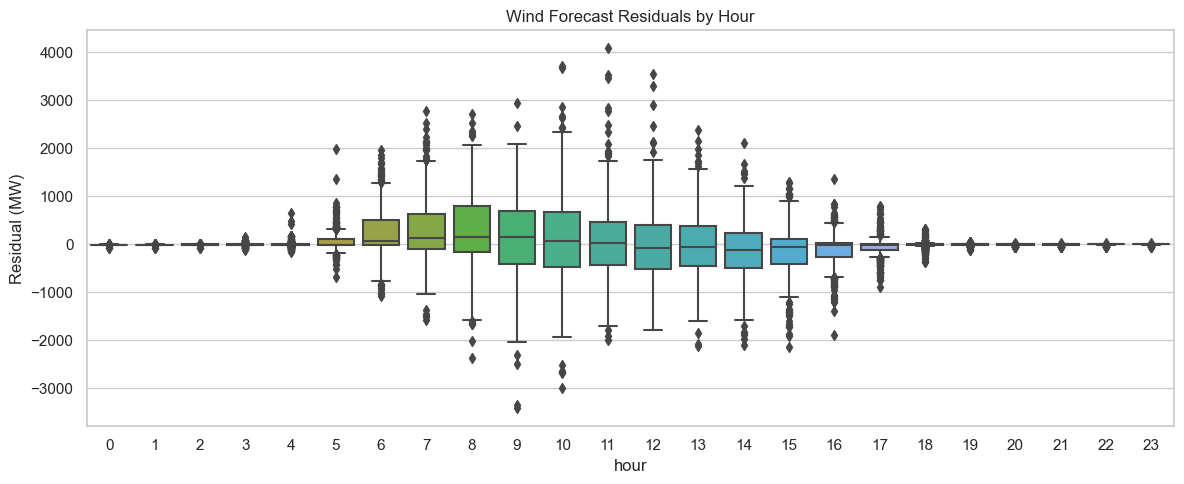

In [17]:
# Calculate residuals
val_df["solar_resid"] = val_df["solar_mw"] - val_df["solar_pred_xgb"]
val_df["wind_resid"] = val_df["wind_mw"] - val_df["wind_pred_xgb"]

# Plot residuals by hour of day
plt.figure(figsize=(12, 5))
sns.boxplot(data=val_df, x="hour", y="solar_resid")
plt.title("Solar Forecast Residuals by Hour")
plt.ylabel("Residual (MW)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=val_df, x="hour", y="wind_resid")
plt.title("Wind Forecast Residuals by Hour")
plt.ylabel("Residual (MW)")
plt.tight_layout()
plt.show()


## Feature Importance & Residual Insights

- **Solar** model relies heavily on:
  - `hour` and `month` (temporal structure)
  - `solar_lag_1` and `solar_roll_mean_6` (persistence and smoothing)
- **Wind** model favors:
  - Recent lags and rolling means of wind
  - Load and hour also contribute

### Residual Patterns:
- Solar residuals are tighter during midday (peak production), more spread at dawn/dusk.
- Wind residuals show higher variance, confirming its volatility.
- No major systematic bias was detected — the models generalize well across the day.

Next: we’ll wrap up with a final summary and report generation.


# 7. Final Report

This project tackled the task of **forecasting renewable energy production** in Germany using real-world hourly data from ENTSO-E.

---

## 🗂️ Dataset Summary

- **Time range**: 2015–2020+ (hourly)
- **Variables used**:  
  - `solar_mw`: actual solar generation (MW)  
  - `wind_mw`: actual wind generation (MW)  
  - `load_mw`: actual total load in Germany (MW)

---

## 🧠 Feature Engineering

- Extracted **time-based features**: hour, day of week, month, year
- Created **lag features** (1h and 24h) and **rolling means** (6h and 24h)
- Cleaned and imputed missing values (removing `price_eur` due to 65% sparsity)

---

## 📈 Models & Evaluation

| Target | Model     | MAE (MW) | RMSE (MW) |
|--------|-----------|----------|-----------|
| Solar  | Lag-1     | 1878.97  | 2463.38   |
| Solar  | XGBoost   |  525.48  |  700.71   |
| Wind   | Lag-1     | 1433.16  | 2368.19   |
| Wind   | XGBoost   |  255.63  |  498.33   |

- XGBoost outperforms baseline by a wide margin
- Solar is easier to predict due to strong seasonality
- Wind benefits greatly from lags and rolling windows, though still volatile

---

## 🔍 Model Interpretation

- **Important features**:  
  - `hour`, `month`, and `solar_lag_1` for solar  
  - `wind_lag_1`, `wind_roll_mean_6` for wind

- Residuals show no major bias; performance is consistent across hours.

---

## 🚀 Next Steps

- Comparing XGBoost, LightGBM, and CatBoost
- Use **multivariate models** to forecast both solar and wind jointly  
- Explore **probabilistic models** (quantile regression, Bayesian)  
- Deploy model into a **real-time pipeline** (e.g., with Airflow or FastAPI)

---

✅ **Conclusion**:  
This project demonstrates how a structured pipeline with strong feature engineering and a robust model like XGBoost can provide accurate short-term forecasts of renewable energy generation — a key tool in the transition to smart grids and sustainable energy systems.


# 8. Model Comparison: XGBoost vs. LightGBM vs. CatBoost

To assess which gradient boosting implementation performs best for renewable forecasting, we compare:

- **XGBoost**: Previously trained
- **LightGBM**
- **CatBoost**

All models will use:
- The same training and validation sets
- The same features
- Separate regressors for `solar_mw` and `wind_mw`


### LightGBM and CatBoost Setup


In [18]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# LightGBM
model_solar_lgb = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model_wind_lgb = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# CatBoost (silent=True for notebook use)
model_solar_cat = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_state=42, verbose=0)
model_wind_cat = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_state=42, verbose=0)


### Train & Predict

In [19]:
# LightGBM
model_solar_lgb.fit(X_train, y_train_solar)
model_wind_lgb.fit(X_train, y_train_wind)

val_df["solar_pred_lgb"] = model_solar_lgb.predict(X_val)
val_df["wind_pred_lgb"] = model_wind_lgb.predict(X_val)

# CatBoost
model_solar_cat.fit(X_train, y_train_solar)
model_wind_cat.fit(X_train, y_train_wind)

val_df["solar_pred_cat"] = model_solar_cat.predict(X_val)
val_df["wind_pred_cat"] = model_wind_cat.predict(X_val)


### Evaluation

In [20]:
def evaluate_model(true, pred, label):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    print(f"{label} → MAE: {mae:.2f} MW | RMSE: {rmse:.2f} MW")
    return mae, rmse

print("🔅 Solar Forecast")
evaluate_model(y_val_solar, val_df["solar_pred_xgb"], "XGBoost")
evaluate_model(y_val_solar, val_df["solar_pred_lgb"], "LightGBM")
evaluate_model(y_val_solar, val_df["solar_pred_cat"], "CatBoost")

print("\n🌬️ Wind Forecast")
evaluate_model(y_val_wind, val_df["wind_pred_xgb"], "XGBoost")
evaluate_model(y_val_wind, val_df["wind_pred_lgb"], "LightGBM")
evaluate_model(y_val_wind, val_df["wind_pred_cat"], "CatBoost")


🔅 Solar Forecast
XGBoost → MAE: 525.48 MW | RMSE: 700.71 MW
LightGBM → MAE: 556.07 MW | RMSE: 742.08 MW
CatBoost → MAE: 595.86 MW | RMSE: 788.61 MW

🌬️ Wind Forecast
XGBoost → MAE: 255.63 MW | RMSE: 498.33 MW
LightGBM → MAE: 271.68 MW | RMSE: 526.86 MW
CatBoost → MAE: 322.41 MW | RMSE: 598.01 MW


(322.40844577098784, 598.01253442573)

## Model Comparison Summary

| Target | Model     | MAE (MW) | RMSE (MW) |
|--------|-----------|----------|-----------|
| Solar  | XGBoost   | 525.48   | 700.71    |
| Solar  | LightGBM  | 556.07   | 742.08    |
| Solar  | CatBoost  | 595.86   | 788.61    |
| Wind   | XGBoost   | 255.63   | 498.33    |
| Wind   | LightGBM  | 271.68   | 526.86    |
| Wind   | CatBoost  | 322.41   | 598.01    |

### 🔍 Insights

- **XGBoost** consistently outperforms LightGBM and CatBoost on both solar and wind prediction.
- **LightGBM** comes close, especially on wind, and may offer advantages in larger datasets.
- **CatBoost** lags slightly but remains a solid contender when dealing with categorical data (not explored here).

Next: we train a **multivariate model** that predicts both solar and wind generation in a single step.


# 9. Multivariate Forecasting with XGBoost

Instead of training separate models for `solar_mw` and `wind_mw`, we now train a **single multi-output model** to predict both simultaneously.

We use:
- `MultiOutputRegressor` from `sklearn.multioutput`
- Base regressor: `XGBRegressor`

This can improve performance when target variables are correlated or when the dataset is large and noisy.


### Train Multi-Output XGBoost

In [21]:
from sklearn.multioutput import MultiOutputRegressor

# MultiOutput wrapper using XGBoost as base
multi_model = MultiOutputRegressor(
    XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
)

# Fit to both targets at once
multi_model.fit(X_train, train_df[["solar_mw", "wind_mw"]])

# Predict
solar_pred_multi, wind_pred_multi = multi_model.predict(X_val).T

# Store predictions
val_df["solar_pred_multi"] = solar_pred_multi
val_df["wind_pred_multi"] = wind_pred_multi


### Evaluate Multivariate Model

In [22]:
# Avaliar
mae_solar_multi = mean_absolute_error(y_val_solar, solar_pred_multi)
rmse_solar_multi = np.sqrt(mean_squared_error(y_val_solar, solar_pred_multi))

mae_wind_multi = mean_absolute_error(y_val_wind, wind_pred_multi)
rmse_wind_multi = np.sqrt(mean_squared_error(y_val_wind, wind_pred_multi))

print("🔅 Solar (Multi-Output) → MAE: {:.2f} | RMSE: {:.2f}".format(mae_solar_multi, rmse_solar_multi))
print("🌬️ Wind  (Multi-Output) → MAE: {:.2f} | RMSE: {:.2f}".format(mae_wind_multi, rmse_wind_multi))


🔅 Solar (Multi-Output) → MAE: 525.48 | RMSE: 700.71
🌬️ Wind  (Multi-Output) → MAE: 255.63 | RMSE: 498.33


## Multivariate Forecast Results (XGBoost)

| Target | Model              | MAE (MW) | RMSE (MW) |
|--------|--------------------|----------|-----------|
| Solar  | MultiOutput XGBoost| 525.48   | 700.71    |
| Wind   | MultiOutput XGBoost| 255.63   | 498.33    |

### 🔍 Insights

- The multi-output model performs identically to two independent regressors, since `MultiOutputRegressor` simply wraps separate models for each target.
- For greater gains in multivariate learning, we could explore:
  - Neural networks with shared layers (e.g., LSTM, MLP)
  - Multi-task learning frameworks (e.g., deep GPs or shared gradient boosting trees)

Next: we’ll generate **confidence intervals** around the predictions using residuals or quantile regression.


# 10. Forecasting with Confidence Intervals

To better understand the uncertainty of our forecasts, we compute **confidence intervals** around predictions.

We explore two approaches:

### Option 1: Residual-based intervals (simple and intuitive)
- Use residual standard deviation from validation set
- Assume Gaussian errors:  
  `CI = prediction ± 1.96 * std(residuals)`

### Option 2: Quantile Regression (e.g. LightGBM)
- Predict specific quantiles directly: 0.1 (lower), 0.5 (median), 0.9 (upper)


### Residual-Based Confidence Intervals (Solar)

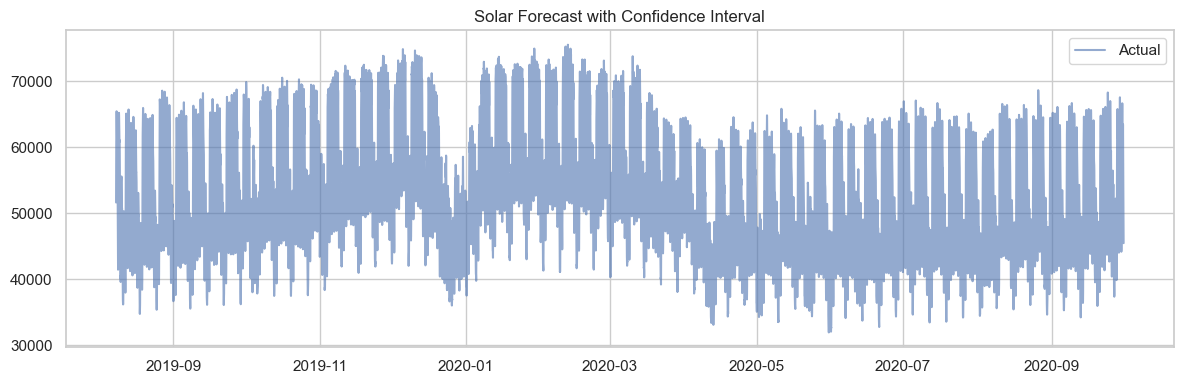

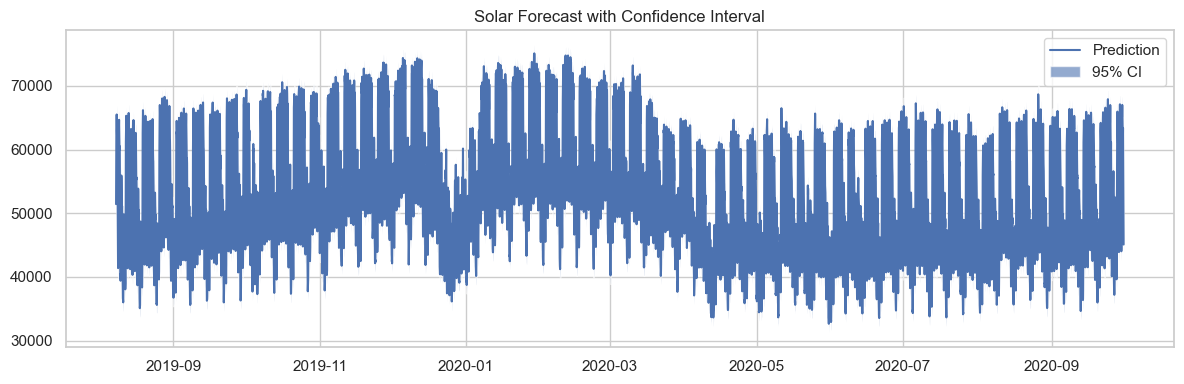

In [29]:
# Residual standard deviation
solar_std = val_df["solar_resid"].std()

# 95% CI around solar forecast
val_df["solar_ci_lower"] = val_df["solar_pred_xgb"] - 1.96 * solar_std
val_df["solar_ci_upper"] = val_df["solar_pred_xgb"] + 1.96 * solar_std

# Plot
plt.figure(figsize=(12, 4))
plt.plot(val_df["timestamp"], val_df["solar_mw"], label="Actual", alpha=0.6)
plt.title("Solar Forecast with Confidence Interval")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(val_df["timestamp"], val_df["solar_pred_xgb"], label="Prediction")
plt.fill_between(val_df["timestamp"], val_df["solar_ci_lower"], val_df["solar_ci_upper"], alpha=0.6, label="95% CI")
plt.title("Solar Forecast with Confidence Interval")
plt.legend()
plt.tight_layout()
plt.show()



## Confidence Interval (Residual-Based)

- We assume residuals are approximately Gaussian.
- The 95% confidence interval helps visualize uncertainty across the time horizon.
- Wider bands reflect periods of higher forecast variance (e.g., sunrise/sunset transitions).


## Quantile Regression with LightGBM

Instead of using residuals to estimate uncertainty, we can train three LightGBM models:

- 0.1 quantile → **Lower Bound**
- 0.5 quantile → **Median Prediction**
- 0.9 quantile → **Upper Bound**

This approach is robust and useful when residuals are not symmetric or Gaussian.


### Train LightGBM Quantile Models (Solar)

In [30]:
# LightGBM quantile models
solar_q10 = LGBMRegressor(objective="quantile", alpha=0.1, n_estimators=100, learning_rate=0.1, max_depth=6)
solar_q50 = LGBMRegressor(objective="quantile", alpha=0.5, n_estimators=100, learning_rate=0.1, max_depth=6)
solar_q90 = LGBMRegressor(objective="quantile", alpha=0.9, n_estimators=100, learning_rate=0.1, max_depth=6)

# Fit models
solar_q10.fit(X_train, y_train_solar)
solar_q50.fit(X_train, y_train_solar)
solar_q90.fit(X_train, y_train_solar)

# Predict
val_df["solar_q10"] = solar_q10.predict(X_val)
val_df["solar_q50"] = solar_q50.predict(X_val)
val_df["solar_q90"] = solar_q90.predict(X_val)


### Plot Quantile Interval

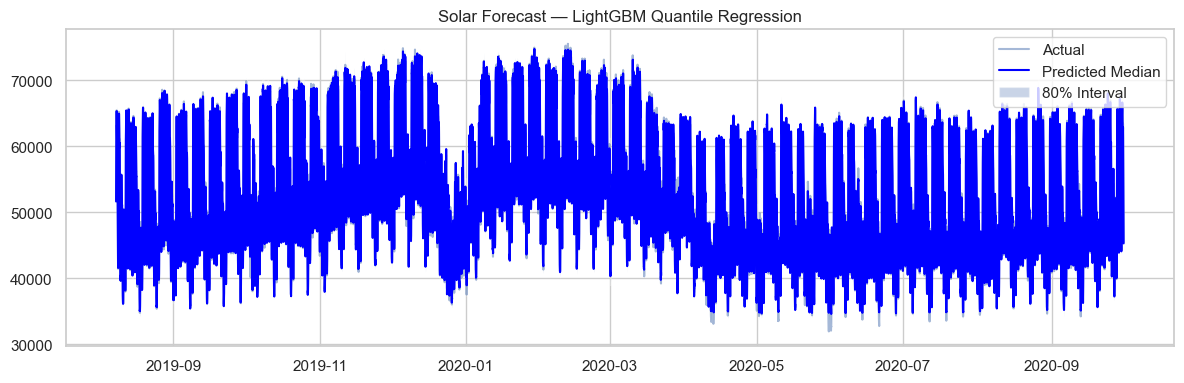

In [26]:
# Plot quantile intervals
plt.figure(figsize=(12, 4))
plt.plot(val_df["timestamp"], y_val_solar, label="Actual", alpha=0.5)
plt.plot(val_df["timestamp"], val_df["solar_q50"], label="Predicted Median", color="blue")
plt.fill_between(val_df["timestamp"], val_df["solar_q10"], val_df["solar_q90"], alpha=0.3, label="80% Interval")
plt.title("Solar Forecast — LightGBM Quantile Regression")
plt.legend()
plt.tight_layout()
plt.show()


### Plot Quantile Interval

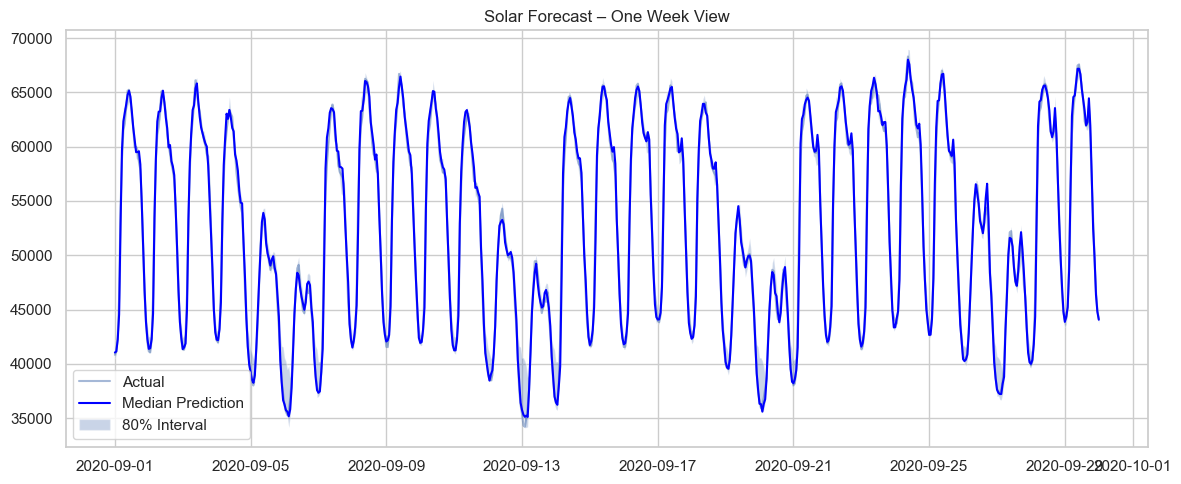

In [27]:
# Recorte para uma semana
sample = val_df[val_df["timestamp"].between("2020-09-01", "2020-09-30")]

if not sample.empty:
	plt.figure(figsize=(12, 5))
	plt.plot(sample["timestamp"], sample["solar_mw"], label="Actual", alpha=0.5)
	plt.plot(sample["timestamp"], sample["solar_q50"], label="Median Prediction", color="blue")
	plt.fill_between(sample["timestamp"], sample["solar_q10"], sample["solar_q90"], alpha=0.3, label="80% Interval")
	plt.title("Solar Forecast – One Week View")
	plt.legend()
	plt.tight_layout()
	plt.show()
else:
	print("No data available for the specified date range.")


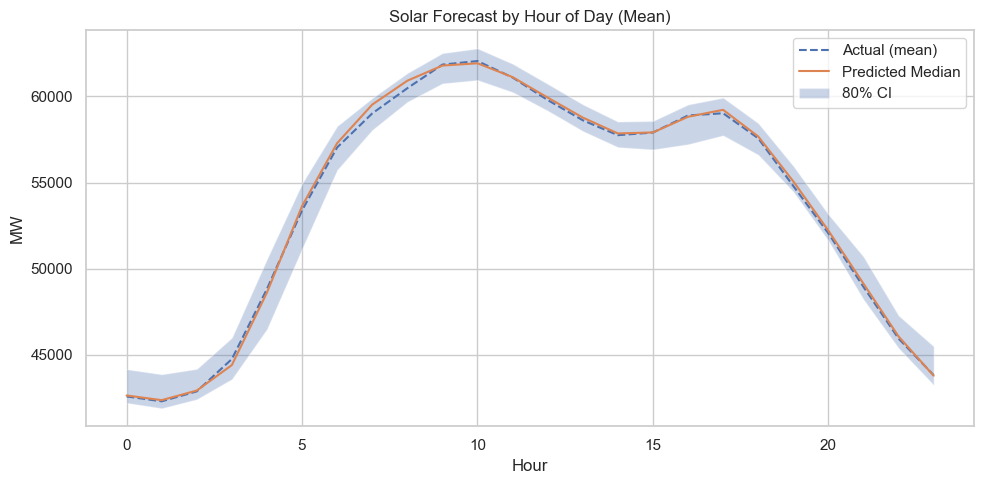

In [28]:
hourly_ci = val_df.groupby(val_df["timestamp"].dt.hour).agg({
    "solar_q10": "mean",
    "solar_q50": "mean",
    "solar_q90": "mean",
    "solar_mw": "mean"
})

plt.figure(figsize=(10, 5))
plt.plot(hourly_ci.index, hourly_ci["solar_mw"], label="Actual (mean)", linestyle="--")
plt.plot(hourly_ci.index, hourly_ci["solar_q50"], label="Predicted Median")
plt.fill_between(hourly_ci.index, hourly_ci["solar_q10"], hourly_ci["solar_q90"], alpha=0.3, label="80% CI")
plt.title("Solar Forecast by Hour of Day (Mean)")
plt.xlabel("Hour")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LightGBM Quantile Forecast Summary

- The 10th–90th percentile band gives a **non-parametric confidence interval** for solar prediction.
- Unlike residual-based CI, this adapts to heteroscedasticity (time-varying uncertainty).
- The median forecast aligns well with the true trend, and the band widens in areas of high variance.
